In [81]:
import { TrainingData } from "./trainingdata.ts";
import { Assets } from "../assets/mod.ts";
import { Community, Investors } from "../repository/mod.ts";
import { DataFrame } from "jsr:@sauber/dataframe";

// Minimum count of future bars to calculate score
const min_bars = 30;

// Assets
const path = "../../testdata";
if (!Deno.statSync(path)) throw new Error(`${path} does not exist.`);
const assets: Assets = Assets.disk(path);
const community: Community = assets.community;
const investors: Investors = await community.all();

// Training Data
const td = new TrainingData(min_bars);
const features: DataFrame = td.generate(investors);

console.log(features.length, "samples generated");
features.print("Training data");
null;


19 samples generated

[ Training data ]
╔═════════════════╤════════╤═══════════╤═══════════════════╤═════════════════════╤═════════╤════════════════════╤═════════╤═══════════╤════════╤══════════════════╤═════════╤══════════╤════════════════════╤═════════════════════╤══════════╤══════════╤════════════╤═════════════════╤═══════════════════╤═════════════════╤══════════════╤════════════╤═════════════╤════════════════╤════════════════════════╤═════════════════════╗
║ PopularInvestor │ Gain   │ RiskScore │ MaxDailyRiskScore │ MaxMonthlyRiskScore │ Copiers │ CopiersGain        │ AUMTier │ AUMTierV2 │ Trades │ WinRatio         │ DailyDD │ WeeklyDD │ ProfitableWeeksPct │ ProfitableMonthsPct │ Velocity │ Exposure │ AvgPosSize │ HighLeveragePct │ MediumLeveragePct │ LowLeveragePct  │ PeakToValley │ LongPosPct │ ActiveWeeks │ ActiveWeeksPct │ WeeksSinceRegistration │ Score               ║
╟─────────────────┼────────┼───────────┼───────────────────┼─────────────────────┼─────────┼──────────────────

null

In [82]:
// Generate parabolic regression line for each input features

import { parabolic, ParabolicResult } from "../math/parabolic.ts";

const data: {feature: string, x: number, y: number, regression: number}[] = [];

// Column names
const names: string[] = features.names.filter((name) => name !== "Score");
const ys: number[] = features.values("Score");

names.map((name) => {
  const values: number[] = features.values(name);
  const pairs: [number, number][] = values.map((g, i) => [g, ys[i]]).sort((a, b) => a[0] - b[0]);
  const par: ParabolicResult = parabolic(pairs);

  if ( isFinite(par.coefficients[0])) {
    // console.log(name, pairs);
    const records = pairs.map((pair) => {
      const x = pair[0];
      const y = pair[1];
      const regression = par.predict(x);
      return { feature: name, x, y, regression };
    });
    data.push(...records);
  }
  else console.log("Not enough data for parabolic regression", name);

});

console.log(data);

null;


Not enough data for parabolic regression PopularInvestor
[
  {
    feature: "Gain",
    x: 29.7,
    y: -0.7114685726275508,
    regression: 0.7751997738098009
  },
  {
    feature: "Gain",
    x: 43.47,
    y: 0.5240517517823068,
    regression: 0.4928430525276851
  },
  {
    feature: "Gain",
    x: 50.53,
    y: 2.1914878789428798,
    regression: 0.3651752555862623
  },
  {
    feature: "Gain",
    x: 51.92,
    y: -0.34934625441448,
    regression: 0.3414052036807994
  },
  {
    feature: "Gain",
    x: 52.12,
    y: 0.1770240006095659,
    regression: 0.33802202690593525
  },
  {
    feature: "Gain",
    x: 53.4,
    y: 2.0701075512471405,
    regression: 0.3165899617147197
  },
  {
    feature: "Gain",
    x: 53.98,
    y: 1.7612703363126925,
    regression: 0.3070039916882239
  },
  {
    feature: "Gain",
    x: 56.7,
    y: -0.6289336081377098,
    regression: 0.26309275756984885
  },
  {
    feature: "Gain",
    x: 58.39,
    y: -1.6340340712487642,
    regression: 0.23667624

null

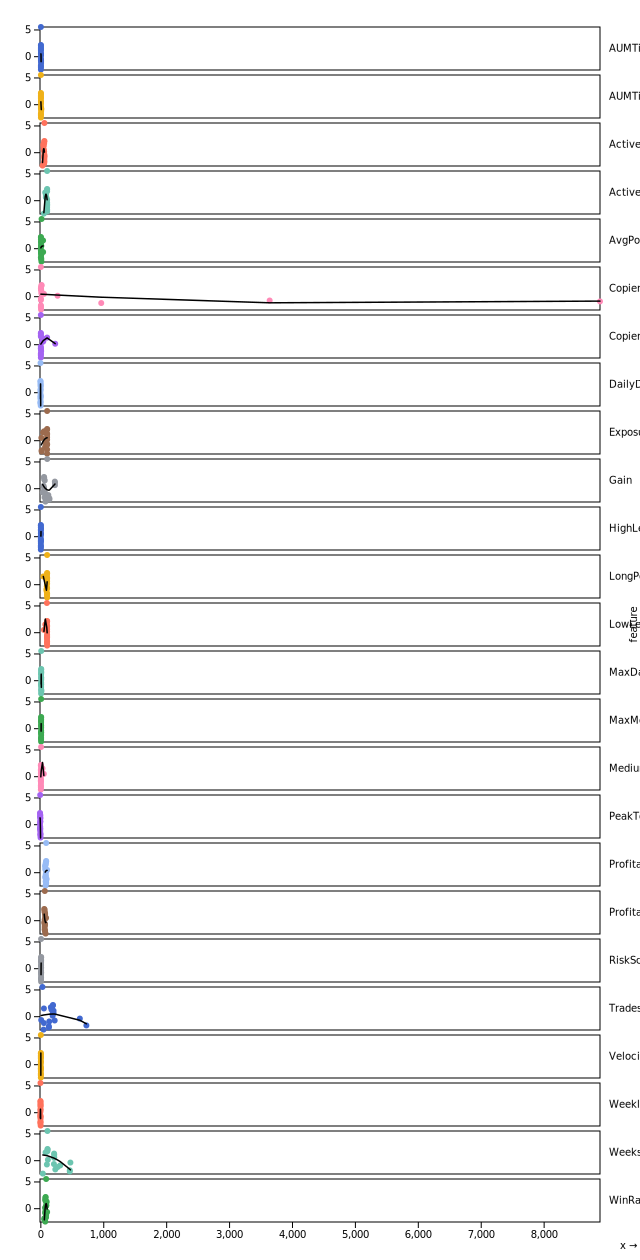

In [84]:
import { document } from "jsr:@ry/jupyter-helper";
import * as Plot from "npm:@observablehq/plot";

Plot.plot({
  facet: {data: data, y: "feature", fill: "feature" },

  marks: [
    Plot.frame(),
    // Plot.dot(data, { x: "x", y: "y", fy: "feature", fill: "feature", facet: "exclude" }),
    // Plot.line(data, { x: "x", y: "regression", fy: "feature", fill: "feature", facet: "exclude" }),
    Plot.dot(data, { x: "x", y: "y", fill: "feature" }),
    Plot.line(data, { x: "x", y: "regression" }),
  ],
  document,
});
